In [1]:
import rasterio
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
import rasterio.features
import rasterio.warp
import glob
import os
import rioxarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
from rasterio.enums import Resampling
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.plot as ep
from shapely.geometry import mapping
import subprocess
from osgeo import gdal
import multiprocessing as mp
from typing import List, Any, Sequence, Tuple
import xarray as xarray
from numpy import savetxt




%matplotlib inline


# Landcover Data

### Importing the Training Region Polygon

In [2]:
#region of interest
studyRegion = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/GeoJSONS/drc_training_new.geojson'
studyRegion = gpd.read_file(studyRegion)
print(studyRegion.head())
print(studyRegion.crs)


                                            geometry
0  POLYGON ((15.24902 -4.32450, 15.18311 -4.36832...
epsg:4326


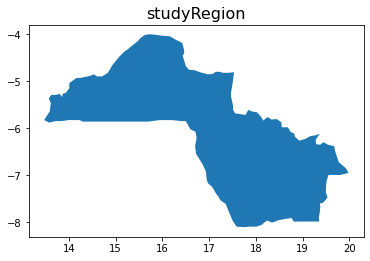

In [3]:
fig, ax = plt.subplots(figsize=(6, 6))

studyRegion.plot(ax=ax)

ax.set_title("studyRegion",
             fontsize=16)
plt.show()

### Importing and Exploring the Landcover Data

In [4]:
#landcover data
ESA_CCI = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/ESA_CCI/TIF/ESA_CCI_LC_Map_2013.tif'
landcover = xr.open_rasterio(ESA_CCI)
print(landcover)


<xarray.DataArray 'lccs_class' (time: 1, y: 64800, x: 129600)>
[8398080000 values with dtype=uint8]
Coordinates:
  * time         (time) object 2013-01-01 00:00:00
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 90.0 90.0 89.99 89.99 ... -89.99 -89.99 -90.0 -90.0
    spatial_ref  int64 0
Attributes:
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [  0.  10.  11.  12.  20.  30.  40.  50.  60.  61. ...
    long_name:            Land cover class defined in LCCS
    standard_name:        land_cover_lccs
    valid_max:            220
    valid_min:            1
    _FillValue:           0.0
    scale_factor:         1.0
    add_offset:           0.0


In [5]:
#landcover classes
landcover_classes = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/ESA_CCI/TIF/ESACCI-LC-Legend.csv'
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


In [6]:
#explore statistics
print(landcover.rio.crs)
print(landcover.rio.nodata)
print(landcover.rio.bounds())
print(landcover.rio.width)
print(landcover.rio.height)
print(landcover.rio.crs.wkt)

EPSG:4326
0
(-180.0, -90.0000000000144, 180.0000000000288, 90.0)
129600
64800
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


In [7]:
#landcover.values
landcover

<xarray.DataArray 'lccs_class' (time: 1, y: 64800, x: 129600)>
[8398080000 values with dtype=uint8]
Coordinates:
  * time         (time) object 2013-01-01 00:00:00
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 90.0 90.0 89.99 89.99 ... -89.99 -89.99 -90.0 -90.0
    spatial_ref  int64 0
Attributes:
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [  0.  10.  11.  12.  20.  30.  40.  50.  60.  61. ...
    long_name:            Land cover class defined in LCCS
    standard_name:        land_cover_lccs
    valid_max:            220
    valid_min:            1
    _FillValue:           0.0
    scale_factor:         1.0
    add_offset:           0.0

### Reproject and Clip the Landcover Data to DRC Cooridnate Projection and Study Region

In [8]:
drc_landcover = landcover.rio.clip(studyRegion.geometry.apply(mapping))

In [9]:
#define projection for DRC
crs_drc = CRS.from_string('EPSG:3341')
landcover_drc_crs = drc_landcover.rio.reproject(crs_drc)

In [10]:
landcover_drc_crs.rio.crs
landcover_drc_crs.shape

(1, 1483, 2353)

In [11]:
landcover_drc_crs.values

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [12]:
#save as raster ahead of reclassification
landcover_drc_crs.rio.to_raster('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/landcover_clipped_reproj.tif')

### Reclassify classes 

In [22]:
training_landcover_path = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/landcover_clipped_reproj.tif'
training_landcover = xr.open_rasterio(training_landcover_path)

def reclassify_landcover(input_array):
    '''input xarray.DataArray with classes and output dataarray with super classes
        but same coords and attributes as input'''

    new_class_1 = np.where((input_array == 10)|(input_array == 20), 
                             1, input_array) #cropland
    new_class_2 = np.where((input_array == 30), 
                             2, new_class_1)#mosaic cropland
    new_class_3 = np.where((input_array == 40), 
                             3, new_class_2)#mosaic vegetation
    new_class_4 = np.where((input_array == 50)|(input_array == 60)|(input_array == 61)|(input_array == 62)|(input_array == 70)|(input_array == 71)|(input_array == 72)|(input_array == 80)|(input_array == 81)|(input_array == 82)|(input_array == 90)|(input_array == 160)|(input_array == 170), 
                             4, new_class_3)#forest
    new_class_5 = np.where((input_array == 11)|(input_array == 12)|(input_array == 100)|(input_array == 110)|(input_array == 120)|(input_array == 121)|(input_array == 122)|(input_array == 150)|(input_array == 151)|(input_array == 152)|(input_array == 153)|(input_array == 180), 
                             5, new_class_4)#shrubland
    new_class_6 = np.where((input_array ==130), 
                             6, new_class_5) #grassland
    new_class_7 = np.where((input_array == 190), 
                             7, new_class_6) #urban
    new_class_8 = np.where((input_array == 210), 
                             8, new_class_7)#water
    #new_class_9 = np.where((input_array == 140)|(input_array == 220)|(input_array == 202)|(input_array == 201)|(input_array == 200), 
                             #9, new_class_8)#other
    new_class_9 = np.where((input_array == 0), 9, new_class_8) #no data

    
    output_array_final = xarray.DataArray(data=new_class_9, coords=input_array.coords, attrs=input_array.attrs)
    
    return output_array_final

#super classes
drc_training_landcover = reclassify_landcover(training_landcover)
superclass_data=[]
superclass_vals = np.unique(drc_training_landcover)
for c in superclass_vals:
    superclass_data.append((drc_training_landcover == c).sum())

superclass_df = pd.DataFrame(superclass_data, index = superclass_vals, columns = ['pixel_count'])   

superclass_df.insert(superclass_df.shape[1], 'class_name', ['Cropland', 'Mosaic Cropland', 'Mosaic Vegetation', 'Forest',
                         'Shrubland', 'Grassland', 'Urban', 'Water'
                                                           ])

superclass_df

ValueError: Length of values (8) does not match length of index (10)

In [19]:
drc_training_landcover.rio.to_raster('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/esa_landcover_training_data.tif')

In [50]:
savetxt('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/drc_training_landcover', drc_training_landcover, delimiter=',')

In [62]:
drc_training_landcover

<xarray.DataArray (band: 1, y: 1483, x: 2353)>
array([[[10, 10, 10, ..., 10, 10, 10],
        [10, 10, 10, ..., 10, 10, 10],
        [10, 10, 10, ..., 10, 10, 10],
        ...,
        [10, 10, 10, ..., 10, 10, 10],
        [10, 10, 10, ..., 10, 10, 10],
        [10, 10, 10, ..., 10, 10, 10]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.192e+05 2.195e+05 ... 9.422e+05 9.425e+05
  * y            (y) float64 9.558e+06 9.558e+06 ... 9.103e+06 9.102e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Land cover class defined in LCCS

In [18]:
#from 3D ----> 2D
drc_training_landcover = landcover_drc_crs[0, :, :]
print(drc_training_landcover.shape)

(1483, 2353)


In [ ]:

# save to csv file
savetxt('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/ESA_Landcover_Data.csv', ESA_Landcover_Data, delimiter=',')

In [ ]:
landcover_drc_crs.values

In [ ]:
# ESA_Landcover_Data.values
ESA_Landcover_Data

In [ ]:
#print(landcover_drc_crs)

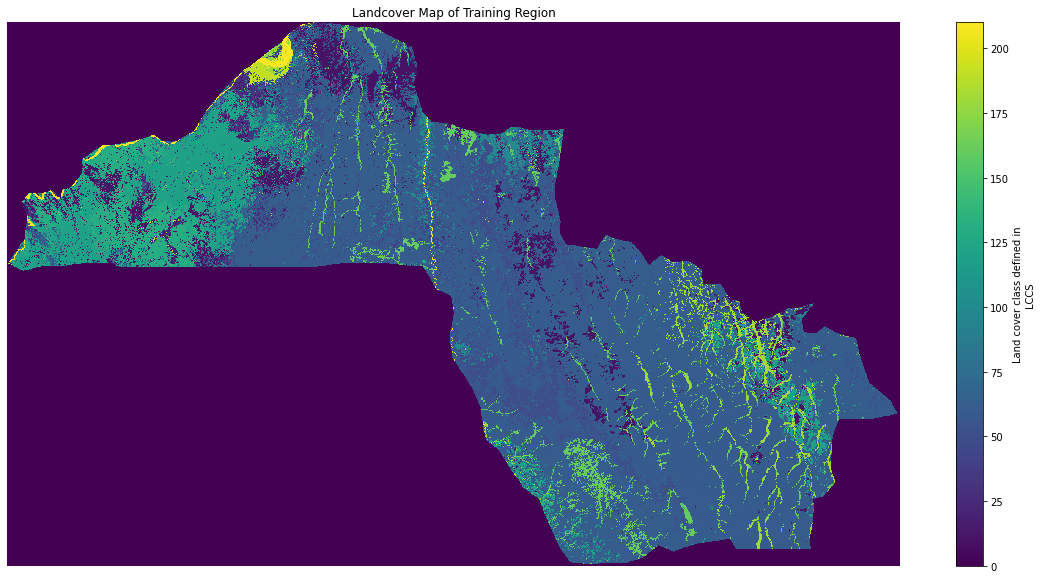

In [52]:
f, ax = plt.subplots(figsize=(20, 10))
landcover_drc_crs.plot(ax=ax)
ax.set(title="Landcover Map of Training Region")
ax.set_axis_off()
plt.savefig('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/landcover_map_of_training_region.png')
plt.show()

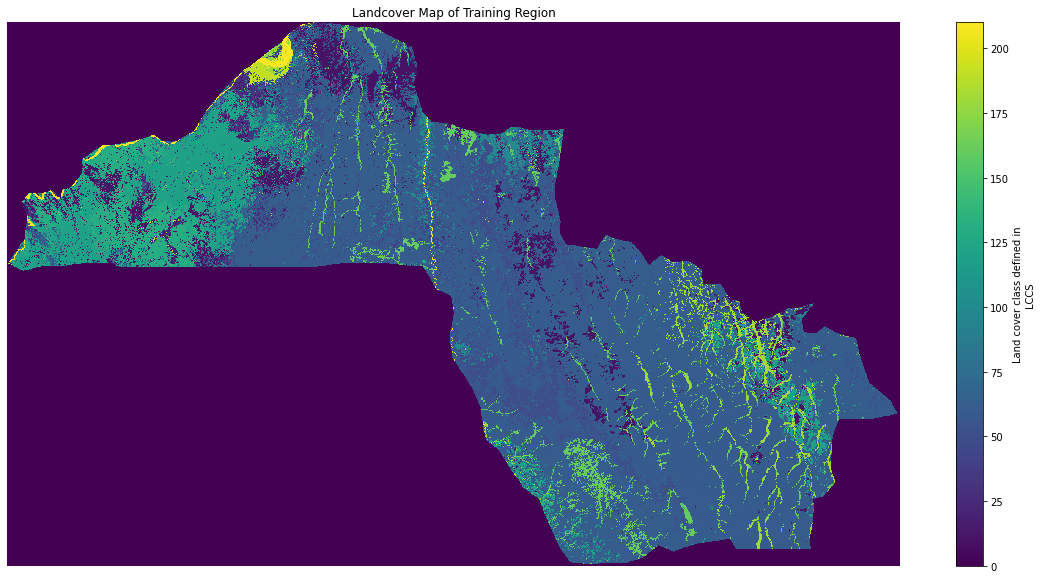

In [53]:
f, ax = plt.subplots(figsize=(20, 10))
drc_training_landcover.plot(ax=ax)
ax.set(title="Landcover Map of Training Region")
ax.set_axis_off()
plt.savefig('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/landcover_map_of_training_region.png')
plt.show()

# Satellite Data

### Importing and Exploring the Satellite Data


In [3]:
#l8 = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/merged_l8_train_data.tif'
l8_reprojected = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/reprojected_l8_train.tif' #the imagery was reprojected in 
#the command line using gdal as rioxarray was re-filloing the array with unwanted values
l8_data = xr.open_rasterio(l8_reprojected)
print(l8_data)

<xarray.DataArray (band: 7, y: 15295, x: 24263)>
[2597718095 values with dtype=float64]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
  * x            (x) float64 2.19e+05 2.19e+05 2.191e+05 ... 9.429e+05 9.429e+05
  * y            (y) float64 9.558e+06 9.558e+06 ... 9.102e+06 9.102e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


In [4]:
#explore statistics
print(l8_data.rio.crs)
print(l8_data.rio.nodata)
print(l8_data.rio.bounds())
print(l8_data.rio.width)
print(l8_data.rio.height)
print(l8_data.rio.crs.wkt)

EPSG:3341
None
(219005.03970397508, 9102067.881812781, 942906.5354010442, 9558403.59366567)
24263
15295
PROJCS["IGCB 1955 / Congo TM zone 16",GEOGCS["IGCB 1955",DATUM["Institut_Geographique_du_Congo_Belge_1955",SPHEROID["Clarke 1880 (RGS)",6378249.145,293.465,AUTHORITY["EPSG","7012"]],TOWGS84[-79.9,-158,-168.9,0,0,0,0],AUTHORITY["EPSG","6701"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4701"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",16],PARAMETER["scale_factor",0.9999],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3341"]]


In [5]:
l8_data.values
#l8_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

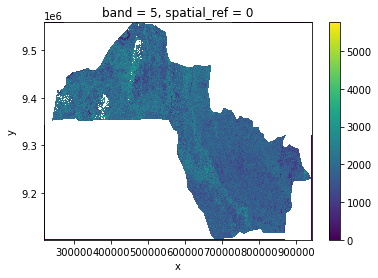

In [45]:
l8_data[4].plot() #plotting one band from the training imagery

In [ ]:
#from 3D ----> 2D
l8_data = l8_data[0, :, :]
print(l8_data.shape)

In [ ]:
from numpy import savetxt

# save to csv file
savetxt('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/Landsat_Satellite_Data_Training.csv', l8_data, delimiter=',')

In [ ]:
l8_data

### Resample Landsat Data to match resolution of Landcover Data

In [6]:
def write_image(arr: np.array, save_path: os.PathLike, **raster_meta) -> None:
    """
    Write a Geotiff to disk with the given raster metadata.
    Convenience function that automatically sets permissions correctly.
    Args:
        arr (np.array): The data to write to disk in geotif format
        save_path (os.PathLike): The path to write to
    """
    with rasterio.open(save_path, "w", **raster_meta) as target:
        target.write(arr)
      # Allow group workspace users access


def downsample_image(
    image: rasterio.DatasetReader,
    bands: List[int],
    downsample_factor: int = 10.311,
    resampling: Resampling = Resampling.bilinear,
) -> Tuple[np.ndarray, Any]:
    """
    Downsample the given bands of a raster image by the given downsample_fator.
    Args:
        image (rasterio.DatasetReader): Rasterio IO handle to the image
        bands (List[int]): The bands to downsample
        downsample_factor (int, optional): Factor by which the image will be
            downsampled. Defaults to 2.
        resampling (Resampling, optional): Resampling algorithm to use. Must be one of
            Rasterio's built-in resampling algorithms. Defaults to Resampling.bilinear.
    Returns:
        Tuple[np.ndarray, Any]: Return the resampled bands of the image as a numpy
            array together with the transform.
    """

    downsampled_image = image.read(
        bands,
        out_shape=(
            int(image.height / downsample_factor),
            int(image.width / downsample_factor),
        ),
        resampling=resampling,
    )

    transform = image.transform * image.transform.scale(
        (image.width / downsampled_image.shape[-1]),
        (image.height / downsampled_image.shape[-2]),
    )

    return downsampled_image, transform


def generate_downsample(
    file_path: os.PathLike,
    downsample_factor: int = 10.311,
    resampling: Resampling = Resampling.bilinear,
    overwrite: bool = False,
) -> None:
    """
    Generate downsample of the raster file at `file_path` and save it in same folder.
    Saved file will have appendix `_downsample_{downsample_factor}x.tif`
    Args:
        file_path (os.PathLike): The path to the raster image todownsample
        downsample_factor (int, optional): The downsampling factor to use.
            Defaults to 2.
        resampling (Resampling, optional): The resampling algorithm to use.
            Defaults to Resampling.bilinear.
        overwrite (bool, optional): Iff True, any existing downsampling file with the
            same downsampling factor will be overwritten. Defaults to False.
    """

    save_path = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/L8_training_data/resampled_satellite.tif'

    with rasterio.open(file_path) as image:
        downsampled_image, transform = downsample_image(
            image,
            image.indexes,
            downsample_factor=downsample_factor,
            resampling=resampling,
        )
        nbands, height, width = downsampled_image.shape

    write_image(
        downsampled_image,
        save_path,
        driver="GTiff",
        height=height,
        width=width,
        count=nbands,
        dtype="float64",
        crs=image.crs,
        transform=transform,
        nodata=image.nodata,
    )


In [7]:
generate_downsample(l8_reprojected)

In [8]:
#visualising resampled landsat imagery
l8_resampled = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/L8_training_data/resampled_satellite.tif'
l8_resampled = xr.open_rasterio(l8_resampled)
print(l8_resampled)

<xarray.DataArray (band: 7, y: 1483, x: 2353)>
[24426493 values with dtype=float64]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
  * x            (x) float64 2.192e+05 2.195e+05 ... 9.424e+05 9.428e+05
  * y            (y) float64 9.558e+06 9.558e+06 ... 9.103e+06 9.102e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


In [10]:
l8_resampled.values

array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.

In [11]:
#remove nan values
l8_filled = l8_resampled.fillna(0)
l8_filled.fillna(0)

<xarray.DataArray (band: 7, y: 1483, x: 2353)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7
  * x            (x) float64 2.192e+05 2.195e+05 ... 9.424e+05 9.428e+05
  * y            (y) float64 9.558e+06 9.558e+06 ... 9.103e+06 9.102e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [12]:
l8_filled.rio.to_raster('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/classification_training_data/filled_l8_training_data.tif')

In [ ]:
#explore statistics
print(l8_resampled.rio.crs)
print(l8_resampled.rio.nodata)
print(l8_resampled.rio.bounds())
print(l8_resampled.rio.width)
print(l8_resampled.rio.height)
print(l8_resampled.rio.crs.wkt)

In [ ]:
### Merge satellite data tiles

"""
import rasterio
import numpy as np
from rasterio.merge import merge
from rasterio.plot import show

dirpath = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles'
search_criteria = 'D*.tif'
q = os.path.join(dirpath, search_criteria)
dem_fps = glob.glob(q)
src_files_to_mosaic = []

for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
mosaic, out_trans = merge(src_files_to_mosaic)




src1 = rasterio.open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/DRC_L8_2013_Training_Image_New-0000000000-0000000000.tif')
src2 = rasterio.open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/DRC_L8_2013_Training_Image_New-0000000000-0000008960.tif')
src3 = rasterio.open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/DRC_L8_2013_Training_Image_New-0000000000-0000017920.tif')
src4 = rasterio.open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/DRC_L8_2013_Training_Image_New-0000008960-0000000000.tif')
src5 = rasterio.open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/DRC_L8_2013_Training_Image_New-0000008960-0000008960.tif')
src6 = rasterio.open('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/training_tiles/DRC_L8_2013_Training_Image_New-0000008960-0000017920.tif')

srcs_to_mosaic = [src1, src2, src3, src4, src5, src6]

# The merge function returns a single array and the affine transform info
arr, out_trans = merge(srcs_to_mosaic)
"""

In [ ]:
#filled_l8_path = '/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/filled_l8_data.tif'
#filled_l8 = xr.open_rasterio(l8)
#l8_data_drc_crs = l8_filled.rio.reproject(crs_drc)
#warp = gdal.Warp('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/reprojected_l8.tif','/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/filled_l8_data.tif',dstSRS='EPSG:3341')


In [ ]:
#l8_filled.rio.to_raster('/gws/nopw/j04/ai4er/users/jl2182/data/Mres_Data/filled_l8_data.tif')

In [ ]:
#l8_filled = l8_data.fillna(0)
#l8_filled.fillna(0)